In [12]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle
import shap
import matplotlib.pyplot as plt
import xgboost

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, log_loss
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [13]:
lgbm_tuned = {
    "learning_rate" : 0.1281147437213422, 
    "max_depth" : 8, 
    "n_estimators" : 993
}
# lgbm_tuned += LIGHTGBM_PARAMS

xgb_tuned = {
    "learning_rate" : 0.11111908522416483, 
    "max_depth" : 7, 
    "n_estimators" : 343
}
# xgb_tuned += XGBOOST_PARAMS


tabnet_tuned = {
    "gamma" : 1.2917828325804677, 
    "lambda_sparse" : 0.0001, 
    "n_steps" : 3,
    "n_a" : 32,
    "momentum" : 0.98,
}

tabnet_tuned["n_d"] = tabnet_tuned["n_a"]

tabnet_paper = {
    "gamma" : 1.2, 
    "lambda_sparse" : 0.0001, 
    "n_steps" : 7,
    "n_a" : 32,
    "momentum" : 0.9,
    "optimizer_params" : dict(lr=1e-2)
}
tabnet_paper["n_d"] = tabnet_paper["n_a"]

xgb_paper = {
    "max_depth" : 6, 
}

lgbm_paper = {
    "num_leaves" : 64,
}

In [14]:
data = pd.read_csv("data/kick_prediction/data_clean.csv")

In [59]:
data.shape

(72983, 44)

In [15]:
train = pd.read_csv("data/kick_prediction/train.csv")
valid = pd.read_csv("data/kick_prediction/val.csv")
test = pd.read_csv("data/kick_prediction/test.csv")

In [16]:
categorical_idx = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34]

categorical_dims = [data.iloc[:, x].nunique() for x in categorical_idx]

In [62]:
len(categorical_idx)

23

In [5]:
for idx in range(0, len(categorical_dims)):
    if categorical_dims[idx] > 1:
        train.iloc[:, categorical_idx[idx]] = [int(x) for x in train.iloc[:, categorical_idx[idx]]]
        valid.iloc[:, categorical_idx[idx]] = [int(x) for x in valid.iloc[:, categorical_idx[idx]]]
        test.iloc[:, categorical_idx[idx]] = [int(x) for x in test.iloc[:, categorical_idx[idx]]]
    else:
        train.iloc[:, categorical_idx[idx]] = [0] * train.shape[0]
        valid.iloc[:, categorical_idx[idx]] = [0] * valid.shape[0]
        test.iloc[:, categorical_idx[idx]] = [0] * test.shape[0]

In [18]:
train = pd.concat([train, valid])

In [19]:
train_X = train.drop(["TARGET"], axis=1)
train_y = train["TARGET"]

test_X = test.drop(["TARGET"], axis=1)
test_y = test["TARGET"]

In [22]:
model_lgbm = LGBMClassifier(**{**lgbm_tuned, **LIGHTGBM_PARAMS})
model_lgbm.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

LGBMClassifier(learning_rate=0.1281147437213422, max_depth=8, metric='auc',
               n_estimators=993, objective='binary', random_state=42)

In [20]:
model_lgbm_paper = LGBMClassifier(**{**lgbm_paper, **LIGHTGBM_PARAMS})
model_lgbm_paper.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

Using categorical_feature in Dataset.


LGBMClassifier(metric='auc', num_leaves=64, objective='binary', random_state=42)

In [23]:
model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
model_xgb.fit(train_X, train_y, verbose=1)

[14:01:58] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:01:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.11111908522416483, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=343, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [21]:
model_xgb_paper = XGBClassifier(**{**xgb_paper, **XGBOOST_PARAMS})
model_xgb_paper.fit(train_X, train_y, verbose=1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:01:45] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:01:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [12]:
TABNET_PARAMS["verbose"] = 1

In [27]:
model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet.fit(train_X.values, train_y.values, max_epochs=30)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.37947 |  0:00:07s
epoch 1  | loss: 0.32056 |  0:00:15s
epoch 2  | loss: 0.31726 |  0:00:23s
epoch 3  | loss: 0.31482 |  0:00:31s
epoch 4  | loss: 0.31453 |  0:00:38s
epoch 5  | loss: 0.31201 |  0:00:46s
epoch 6  | loss: 0.31254 |  0:00:54s
epoch 7  | loss: 0.31201 |  0:01:01s
epoch 8  | loss: 0.31007 |  0:01:09s
epoch 9  | loss: 0.30877 |  0:01:17s
epoch 10 | loss: 0.30848 |  0:01:25s
epoch 11 | loss: 0.30685 |  0:01:32s
epoch 12 | loss: 0.30707 |  0:01:40s
epoch 13 | loss: 0.3063  |  0:01:48s
epoch 14 | loss: 0.30583 |  0:01:56s
epoch 15 | loss: 0.30433 |  0:02:03s
epoch 16 | loss: 0.30321 |  0:02:11s
epoch 17 | loss: 0.30188 |  0:02:19s
epoch 18 | loss: 0.2998  |  0:02:26s
epoch 19 | loss: 0.29933 |  0:02:34s
epoch 20 | loss: 0.29631 |  0:02:42s
epoch 21 | loss: 0.29734 |  0:02:50s
epoch 22 | loss: 0.29595 |  0:02:57s
epoch 23 | loss: 0.29765 |  0:03:05s
epoch 24 | loss: 0.29

In [14]:
model_tabnet_paper = TabNetClassifier(**{**tabnet_paper, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet_paper.fit(train_X.values, train_y.values, max_epochs=45, batch_size=8192, virtual_batch_size=256)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.68364 |  0:01:05s
epoch 1  | loss: 0.15025 |  0:02:10s
epoch 2  | loss: 0.14513 |  0:03:12s
epoch 3  | loss: 0.13577 |  0:04:17s
epoch 4  | loss: 0.13261 |  0:05:19s
epoch 5  | loss: 0.12932 |  0:06:19s
epoch 6  | loss: 0.11857 |  0:07:25s
epoch 7  | loss: 0.11329 |  0:08:30s
epoch 8  | loss: 0.11013 |  0:09:31s
epoch 9  | loss: 0.10445 |  0:10:35s
epoch 10 | loss: 0.10074 |  0:11:38s
epoch 11 | loss: 0.10024 |  0:12:41s
epoch 12 | loss: 0.09873 |  0:13:43s
epoch 13 | loss: 0.09217 |  0:14:48s
epoch 14 | loss: 0.09167 |  0:15:52s
epoch 15 | loss: 0.09026 |  0:16:58s
epoch 16 | loss: 0.08836 |  0:18:04s
epoch 17 | loss: 0.08998 |  0:19:08s
epoch 18 | loss: 0.08803 |  0:20:14s
epoch 19 | loss: 0.08802 |  0:21:20s
epoch 20 | loss: 0.08541 |  0:22:23s
epoch 21 | loss: 0.08599 |  0:23:28s
epoch 22 | loss: 0.08623 |  0:24:33s
epoch 23 | loss: 0.08545 |  0:25:37s
epoch 24 | loss: 0.08

In [175]:
with open('model_tabnet_kdd_appetency.pickle', 'wb') as f:
    pickle.dump(model_tabnet, f)
with open('model_tabnet_paper_kdd_appetency.pickle', 'wb') as f:
    pickle.dump(model_tabnet_paper, f)

In [10]:
with open('model_tabnet.pickle', 'rb') as f:
    model_tabnet = pickle.load(f)
with open('model_tabnet_paper.pickle', 'rb') as f:
    model_tabnet_paper = pickle.load(f)

In [30]:
print("LightGBM auc: ", round(roc_auc_score(test_y, model_lgbm.predict_proba(test_X)[:, 1]), 6))
print("LightGBM Paper auc: ", round(roc_auc_score(test_y, model_lgbm_paper.predict_proba(test_X)[:, 1]), 6))
print("XGBoost auc: ", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X)[:, 1]), 6))
print("XGBoost Paper auc: ", round(roc_auc_score(test_y, model_xgb_paper.predict_proba(test_X)[:, 1]), 6))
print("TabNet auc: ", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X.values)[:, 1]), 6))

LightGBM auc:  0.747989
LightGBM Paper auc:  0.764274
XGBoost auc:  0.770257
XGBoost Paper auc:  0.77188
TabNet auc:  0.760058


In [28]:
print("LightGBM acc: ", round(accuracy_score(test_y, model_lgbm.predict(test_X)), 6))
print("LightGBM Paper acc: ", round(accuracy_score(test_y, model_lgbm_paper.predict(test_X)), 6))
print("XGBoost acc: ", round(accuracy_score(test_y, model_xgb.predict(test_X)), 6))
print("XGBoost Paper acc: ", round(accuracy_score(test_y, model_xgb_paper.predict(test_X)), 6))
print("TabNet acc: ", round(accuracy_score(test_y, model_tabnet.predict(test_X.values)), 6))

LightGBM acc:  0.898886
LightGBM Paper acc:  0.903179
XGBoost acc:  0.903453
XGBoost Paper acc:  0.901443
TabNet acc:  0.900712


In [29]:
print("LightGBM log_loss: ", round(log_loss(test_y, model_lgbm.predict_proba(test_X)), 6))
print("LightGBM Paper log_loss: ", round(log_loss(test_y, model_lgbm_paper.predict_proba(test_X)), 6))
print("XGBoost log_loss: ", round(log_loss(test_y, model_xgb.predict_proba(test_X)), 6))
print("XGBoost Paper log_loss: ", round(log_loss(test_y, model_xgb_paper.predict_proba(test_X)), 6))
print("TabNet log_loss: ", round(log_loss(test_y, model_tabnet.predict_proba(test_X.values)), 6))

LightGBM log_loss:  0.371005
LightGBM Paper log_loss:  0.298891
XGBoost log_loss:  0.297067
XGBoost Paper log_loss:  0.296704
TabNet log_loss:  0.306538


In [34]:
importance_lgbm = list(enumerate(model_lgbm.feature_importances_))
importance_lgbm_paper = list(enumerate(model_lgbm_paper.feature_importances_))
importance_xgb = model_xgb.get_booster().get_score(importance_type='weight').items()
importance_xgb_paper = model_xgb_paper.get_booster().get_score(importance_type='weight').items()
importance_tabnet = list(enumerate(model_tabnet.feature_importances_))
# importance_tabnet_paper = list(enumerate(model_tabnet_paper.feature_importances_))

In [35]:
importance_lgbm = sorted(importance_lgbm, key=lambda x: x[1], reverse=True)
importance_lgbm = sorted(importance_lgbm_paper, key=lambda x: x[1], reverse=True)
importance_xgb = sorted(importance_xgb, key=lambda x: x[1], reverse=True)
importance_xgb_paper = sorted(importance_xgb_paper, key=lambda x: x[1], reverse=True)
importance_tabnet = sorted(importance_tabnet, key=lambda x: x[1], reverse=True)
# importance_tabnet_paper = sorted(importance_tabnet_paper, key=lambda x: x[1], reverse=True)

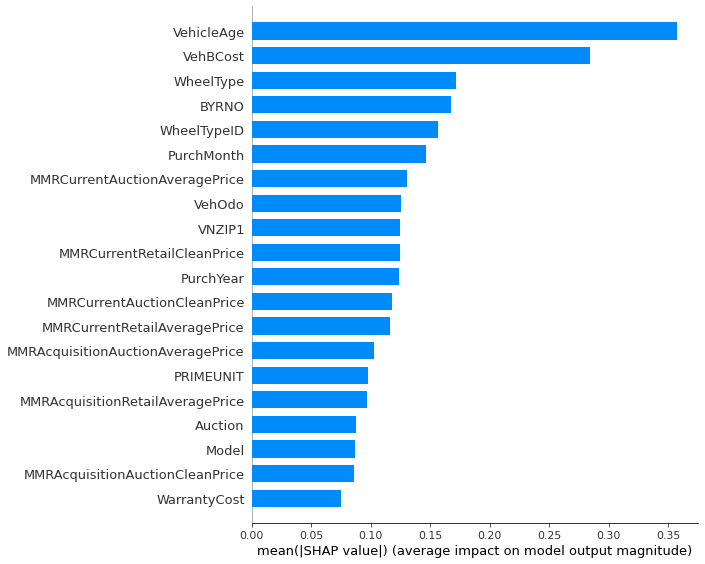

In [31]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(train_X)
shap.summary_plot(shap_values, train_X, plot_type="bar")

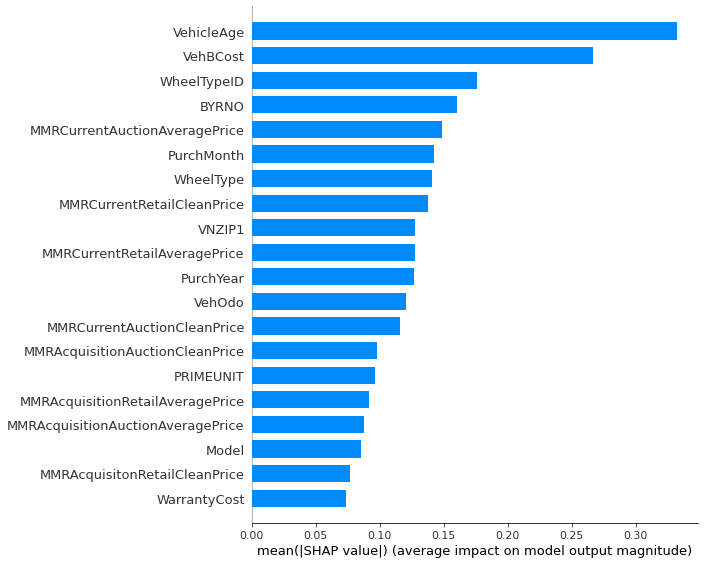

In [32]:
shap_values_paper = shap.TreeExplainer(model_xgb_paper).shap_values(train_X)
shap.summary_plot(shap_values_paper, train_X, plot_type="bar")

In [61]:
np.argsort(np.abs(shap_values_paper).mean(0))

array([42, 29, 35, 36, 38, 37, 40, 41, 39, 24, 12,  8,  7, 14,  1, 13, 34,
       27,  3,  5, 33,  6,  0, 30, 18,  4, 15, 17, 23, 16, 20, 11, 31, 21,
       26, 22, 10, 32, 19, 25,  9, 28,  2])

In [40]:
df_compare = pd.DataFrame([train_X.columns[x[0]] for x in importance_lgbm], columns=["LightGBM"])
df_compare["LightGBM_Paper"] = [train_X.columns[x[0]] for x in importance_lgbm]
# df_compare["XGBoost"] = [x[0] for x in importance_xgb] + list(set(train_X.columns[:-1]) - set([x[0] for x in importance_xgb])) + [train_X.columns[-1]]
df_compare["XGBoost_Paper"] = [x[0] for x in importance_xgb_paper] + list(set(train_X.columns[:-1]) - set([x[0] for x in importance_xgb_paper])) + [train_X.columns[-1]]
# df_compare["SHAP_XGBoost"] = train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]
df_compare["SHAP_XGBoost_Paper"] = train_X.columns[np.argsort(np.abs(shap_values_paper).mean(0))][::-1]
df_compare["TabNet"] = [train_X.columns[x[0]] for x in importance_tabnet]
# df_compare["TabNet_Paper"] = [train_X.columns[x[0]] for x in importance_tabnet_paper]

In [41]:
df_compare.head(10)

,LightGBM,LightGBM_Paper,XGBoost_Paper,SHAP_XGBoost_Paper,TabNet
0,Model,Model,VehOdo,VehicleAge,WheelTypeID
1,PurchDay,PurchDay,VehBCost,VehBCost,Nationality
2,VNZIP1,VNZIP1,VNZIP1,WheelTypeID,VehicleAge
3,SubModel,SubModel,BYRNO,BYRNO,VehBCost
4,BYRNO,BYRNO,Model,MMRCurrentAuctionAveragePrice,TopThreeAmericanName
5,VehOdo,VehOdo,PurchDay,PurchMonth,PurchWeekday
6,VehBCost,VehBCost,WarrantyCost,WheelType,PRIMEUNIT
7,MMRCurrentRetailAveragePrice,MMRCurrentRetailAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailCleanPrice,VNST
8,PurchMonth,PurchMonth,MMRCurrentAuctionAveragePrice,VNZIP1,VehYear
9,MMRCurrentRetailCleanPrice,MMRCurrentRetailCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailAveragePrice,WarrantyCost


In [49]:
top3_feats = {}
top3_feats["xgboost"] = ["VehOdo", "VehBCost", "VNZIP1"]
top3_feats["shap"] = ["VehicleAge", "VehBCost", "WheelTypeID"]
top3_feats["tabnet"] = ["WheelTypeID", "Nationality", "VehicleAge"]

In [50]:
top10_feats = {}
top10_feats["xgboost"] = ["VehOdo", "VehBCost", "VNZIP1", "BYRNO", "Model", "PurchDay", "WarrantyCost", "MMRCurrentAuctionCleanPrice", "MMRCurrentAuctionAveragePrice", "MMRCurrentRetailAveragePrice"]
top10_feats["shap"] = ["VehicleAge", "VehBCost", "WheelTypeID", "BYRNO", "MMRCurrentAuctionAveragePrice", "PurchMonth", "WheelType", "MMRCurrentRetailCleanPrice", "VNZIP1", "MMRCurrentRetailAveragePrice"]
top10_feats["tabnet"] = ["WheelTypeID", "Nationality", "VehicleAge", "VehBCost", "TopThreeAmericanName", "PurchWeekday", "PRIMEUNIT", "VNST", "VehYear", "WarrantyCost"]

In [43]:
top_3 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:2, col1]) & set(df_compare.loc[:2, col2])))
        top_3.append(d)
top_3_data = pd.DataFrame(top_3, columns=["Model1", "Model2", "Sim"])
    

In [44]:
pd.pivot_table(top_3_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost_Paper,TabNet,XGBoost_Paper
Model1,,,,,
LightGBM,3,3,0,0,1
LightGBM_Paper,3,3,0,0,1
SHAP_XGBoost_Paper,0,0,3,2,1
TabNet,0,0,2,3,0
XGBoost_Paper,1,1,1,0,3


In [45]:
top_5 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:4, col1]) & set(df_compare.loc[:4, col2])))
        top_5.append(d)
top_5_data = pd.DataFrame(top_5, columns=["Model1", "Model2", "Sim"])
    

In [46]:
pd.pivot_table(top_5_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost_Paper,TabNet,XGBoost_Paper
Model1,,,,,
LightGBM,5,5,1,0,3
LightGBM_Paper,5,5,1,0,3
SHAP_XGBoost_Paper,1,1,5,3,2
TabNet,0,0,3,5,1
XGBoost_Paper,3,3,2,1,5


In [47]:
top_10 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:9, col1]) & set(df_compare.loc[:9, col2])))
        top_10.append(d)
top_10_data = pd.DataFrame(top_10, columns=["Model1", "Model2", "Sim"])
    

In [48]:
pd.pivot_table(top_10_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost_Paper,TabNet,XGBoost_Paper
Model1,,,,,
LightGBM,10,10,6,1,7
LightGBM_Paper,10,10,6,1,7
SHAP_XGBoost_Paper,6,6,10,3,5
TabNet,1,1,3,10,2
XGBoost_Paper,7,7,5,2,10


In [53]:
top3_results = []
for model, feats in top3_feats.items():
    train_X_slice = train_X[feats]
    test_X_slice = test_X[feats]
    cat_feats = set(train_X_slice.columns) & set([train_X.columns[x] for x in categorical_idx])
    cat_idx = sorted([list(train_X_slice.columns).index(x) for x in cat_feats])
    cat_dims = [len(set(list(train_X_slice.iloc[:, x].unique()) + list(test_X_slice.iloc[:, x].unique()))) for x in cat_idx]
    
    model_xgb = XGBClassifier(**{**xgb_paper, **XGBOOST_PARAMS})
    model_xgb.fit(train_X_slice, train_y, verbose=1)
    top3_results.append([model, "XGBoost", "acc", round(accuracy_score(test_y, model_xgb.predict(test_X_slice)), 6)])
    top3_results.append([model, "XGBoost", "auc", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X_slice)[:, 1]), 6)])
    result = []
    model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=cat_idx, cat_dims=cat_dims)
    model_tabnet.fit(train_X_slice.values, train_y.values, max_epochs=30)
    top3_results.append([model, "TabNet", "acc", round(accuracy_score(test_y, model_tabnet.predict(test_X_slice.values)), 6)])
    top3_results.append([model, "TabNet", "auc", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X_slice.values)[:, 1]), 6)])
    

[14:19:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:19:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.40028 |  0:00:07s
epoch 1  | loss: 0.36723 |  0:00:14s
epoch 2  | loss: 0.36474 |  0:00:22s
epoch 3  | loss: 0.3631  |  0:00:29s
epoch 4  | loss: 0.36242 |  0:00:36s
epoch 5  | loss: 0.36172 |  0:00:44s
epoch 6  | loss: 0.3606  |  0:00:51s
epoch 7  | loss: 0.36042 |  0:00:58s
epoch 8  | loss: 0.36126 |  0:01:05

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:22:58] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:22:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.378   |  0:00:07s
epoch 1  | loss: 0.31985 |  0:00:15s
epoch 2  | loss: 0.31762 |  0:00:22s
epoch 3  | loss: 0.31683 |  0:00:30s
epoch 4  | loss: 0.31646 |  0:00:37s
epoch 5  | loss: 0.31653 |  0:00:44s
epoch 6  | loss: 0.31611 |  0:00:51s
epoch 7  | loss: 0.3154  |  0:00:59s
epoch 8  | loss: 0.31489 |  0:01:06

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:26:43] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:26:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.35676 |  0:00:07s
epoch 1  | loss: 0.32234 |  0:00:14s
epoch 2  | loss: 0.31943 |  0:00:22s
epoch 3  | loss: 0.31911 |  0:00:30s
epoch 4  | loss: 0.31789 |  0:00:39s
epoch 5  | loss: 0.3175  |  0:00:46s
epoch 6  | loss: 0.31824 |  0:00:54s
epoch 7  | loss: 0.31851 |  0:01:01s
epoch 8  | loss: 0.31838 |  0:01:09

In [54]:
top_3_scores = pd.DataFrame(top3_results, columns=["Features", "Model", "Score", "Value"])

In [55]:
pd.pivot_table(top_3_scores, values='Value', index=['Features'], columns=['Model', "Score"])

Model       TabNet             XGBoost          
Score          acc       auc       acc       auc
Features                                        
shap      0.894593  0.741298  0.893679  0.739811
tabnet    0.894501  0.733256  0.894501  0.733235
xgboost   0.877055  0.640115  0.875776  0.620905

In [56]:
top10_results = []
for model, feats in top10_feats.items():
    train_X_slice = train_X[feats]
    test_X_slice = test_X[feats]
    cat_feats = set(train_X_slice.columns) & set([train_X.columns[x] for x in categorical_idx])
    cat_idx = sorted([list(train_X_slice.columns).index(x) for x in cat_feats])
    cat_dims = [len(set(list(train_X_slice.iloc[:, x].unique()) + list(test_X_slice.iloc[:, x].unique()))) for x in cat_idx]
    
    model_xgb = XGBClassifier(**{**xgb_paper, **XGBOOST_PARAMS})
    model_xgb.fit(train_X_slice, train_y, verbose=1)
    top10_results.append([model, "XGBoost", "acc", round(accuracy_score(test_y, model_xgb.predict(test_X_slice)), 6)])
    top10_results.append([model, "XGBoost", "auc", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X_slice)[:, 1]), 6)])
    result = []
    model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=cat_idx, cat_dims=cat_dims)
    model_tabnet.fit(train_X_slice.values, train_y.values, max_epochs=30)
    top10_results.append([model, "TabNet", "acc", round(accuracy_score(test_y, model_tabnet.predict(test_X_slice.values)), 6)])
    top10_results.append([model, "TabNet", "auc", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X_slice.values)[:, 1]), 6)])
    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:30:38] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:30:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.38723 |  0:00:07s
epoch 1  | loss: 0.36603 |  0:00:15s
epoch 2  | loss: 0.3638  |  0:00:22s
epoch 3  | loss: 0.36233 |  0:00:30s
epoch 4  | loss: 0.36276 |  0:00:38s
epoch 5  | loss: 0.36128 |  0:00:45s
epoch 6  | loss: 0.35915 |  0:00:53s
epoch 7  | loss: 0.3588  |  0:01:00s
epoch 8  | loss: 0.35732 |  0:01:08

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:34:38] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:34:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.35438 |  0:00:07s
epoch 1  | loss: 0.32018 |  0:00:15s
epoch 2  | loss: 0.31798 |  0:00:23s
epoch 3  | loss: 0.31765 |  0:00:31s
epoch 4  | loss: 0.31689 |  0:00:39s
epoch 5  | loss: 0.31615 |  0:00:47s
epoch 6  | loss: 0.31639 |  0:00:55s
epoch 7  | loss: 0.31499 |  0:01:03s
epoch 8  | loss: 0.3152  |  0:01:10

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[14:38:50] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:38:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.38096 |  0:00:08s
epoch 1  | loss: 0.32079 |  0:00:17s
epoch 2  | loss: 0.31878 |  0:00:25s
epoch 3  | loss: 0.31577 |  0:00:33s
epoch 4  | loss: 0.31581 |  0:00:42s
epoch 5  | loss: 0.31616 |  0:00:55s
epoch 6  | loss: 0.31554 |  0:01:10s
epoch 7  | loss: 0.31427 |  0:01:25s
epoch 8  | loss: 0.3133  |  0:01:35

In [57]:
top_10_scores = pd.DataFrame(top10_results, columns=["Features", "Model", "Score", "Value"])

In [58]:
pd.pivot_table(top_10_scores, values='Value', index=['Features'], columns=['Model', "Score"])

Model       TabNet             XGBoost          
Score          acc       auc       acc       auc
Features                                        
shap      0.894684  0.752550  0.901626  0.750535
tabnet    0.894775  0.753915  0.897790  0.750670
xgboost   0.876324  0.659135  0.876050  0.666310